## **Installing requiered libraries and getting git repository**

In [1]:
#Build essentials
!pip install deap
!pip install gensim
!pip install torch==1.7.1 torchvision==0.8.2 torchaudio==0.7.2
!pip install -U scikit-learn
!pip install -U skorch
!pip install datasets
!pip install -U nltk
!pip install torchsummary
!pip install pytorch-model-summary
!pip install matplotlib
!pip install seaborn
!pip install simpletransformers    

# Clone from GitHub
!git clone https://github.com/ajhglez99/Rest_mex_DL_EDA.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached torch-1.7.1-cp37-cp37m-manylinux1_x86_64.whl (776.8 MB)
  Using cached torchvision-0.8.2-cp37-cp37m-manylinux1_x86_64.whl (12.8 MB)
  Using cached torchaudio-0.7.2-cp37-cp37m-manylinux1_x86_64.whl (7.6 MB)
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.13.1+cu113
    Uninstalling torchvision-0.13.1+cu113:
      Successfully uninstalled torchvision-0.13.1+cu113
  Attempting uninstall: torchaudio
    Found existing installation: torchaudio 0.12.1+cu113
    Uninstalling torchaudio-0.12.1+cu113:
      Successfully uninstalled torchaudio-0.12.1+cu113
ERROR: pip's dependency resolver does not currently take into account all the packages that are inst

## **Computing metrics, convengence charts and confusion matrix**

In [2]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

def confusion_matrix_chart(test_accs,train_accs, confusion_mtxes, labels, epoches, url_img, figsize=(20, 8)):
    cm = confusion_mtxes[np.argmax(test_accs)]
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum * 100
    annot = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cm_perc[i, j]
            if c == 0:
                annot[i, j] = ''
            else:
                annot[i, j] = '%.1f%%' % p
    cm = pd.DataFrame(cm, index=labels, columns=labels)
    cm.index.name = 'Actual'
    cm.columns.name = 'Predicted'

    fig = plt.figure(figsize=figsize)
    x_axis= np.asarray([x for x in range(epoches)])
    plt.subplot(1, 2, 1)
    plt.plot(x_axis,test_accs, 'g')
    plt.xlabel("Epoches")
    plt.plot(x_axis,train_accs,'r')
    plt.ylabel("Accuracy")
    plt.grid(True)

    plt.subplot(1, 2, 2)
    sns.heatmap(cm, annot=annot, fmt='', cmap="Blues")
    plt.savefig(url_img+'figure.png')
    plt.show()

# **Loading of model hyperparameters via a configuration file script/arguments.txt in the training methods**

In [3]:
import os
import sys
os.system("export PYTORCH_CUDA_ALLOC_CONF=max_split_size_mb:20")
sys.path.append("/content/Rest_mex_DL_EDA/")
import time

# ------ Scikit-learn ----------------------------------------------------------+
from sklearn.model_selection import GridSearchCV
from skorch.callbacks import Checkpoint, LoadInitState,EarlyStopping

# ------ Tranformesrs ----------------------------------------------------------+
from transformers import T5Tokenizer
from transformers.models.mt5 import MT5ForConditionalGeneration
import torch
from torch.optim import AdamW

from algorithms_models.model_mt5_emoeval_builder import CustomMT5Model
from algorithms_models.trainer_mt5 import Trainer
from algorithms_models.trainer_mt5_custom import TrainerMT5Custom
from algorithms_models import model_mt5_emoeval_builder


def train_model_t5_custom_polarity(dic_param, log_exp_run, wdir, device, train_data, test_data, gscv_best_model):
    # Defining a param distribution for hyperparameter-tuning for model and fit params
    param_grid = {
        'lr': dic_param['alpha_distribution'],
        'mode': ["train"]
    }

    fit_param = {
        'patientia': dic_param['sgd_early_stopping_patientia'],
        'min_diference': dic_param['sgd_min_difference'],
        'checkpoint_path': wdir + "checkpoints/", 'test_data': test_data, 'is_unbalanced': False, 'task': 'main'
    }

    checkpoint = Checkpoint(dirname=fit_param['checkpoint_path'], f_params=dic_param['f_params_name'],
                            f_optimizer=dic_param['f_optimizer_name'], f_history=dic_param['f_history_name'],
                            f_criterion=dic_param['f_criterion_name'],
                            monitor=None)

    load_state = LoadInitState(checkpoint)

    # Defining skorch-based neural network
    tokenizer = T5Tokenizer.from_pretrained("google/mt5-small")

    trainer = TrainerMT5Custom(
        module=CustomMT5Model,
        module__labels=5,
        max_epochs=dic_param['epochs'],
        tokenizer=tokenizer,
        iterator_train__shuffle=True,
        train_split=None,
        batch_size=dic_param['sgd_batch_size'],
        device=device,
        callbacks=[checkpoint],
        criterion=torch.nn.CrossEntropyLoss,
        optimizer=AdamW,
        lr=6e-5,
        optimizer__weight_decay=dic_param['weight_decay'],
        mode="train"
    )

    trainer.fit(train_data, fit_param=fit_param)
    trainer.score_unbalance(test_data)
    trainer.score_unbalance(train_data, is_unbalanced=False)
    confusion_matrix_chart(trainer.test_accs, trainer.train_accs, trainer.confusion_mtxes,
                           range(5), dic_param['epochs'], wdir + "experiments/")

    return gscv_best_model

def train_model_t5_custom_attraction(dic_param, log_exp_run, wdir, device, train_data, test_data, gscv_best_model):
    # Defining a param distribution for hyperparameter-tuning for model and fit params
    param_grid = {
        'lr': dic_param['alpha_distribution'],
        'mode': ["train"]
    }

    fit_param = {
        'patientia': dic_param['sgd_early_stopping_patientia'],
        'min_diference': dic_param['sgd_min_difference'],
        'checkpoint_path': wdir + "checkpoints/", 'test_data': test_data, 'is_unbalanced': False, 'task': 'attraction'
    }

    checkpoint = Checkpoint(dirname=fit_param['checkpoint_path'], f_params=dic_param['f_params_name'],
                            f_optimizer=dic_param['f_optimizer_name'], f_history=dic_param['f_history_name'],
                            f_criterion=dic_param['f_criterion_name'],
                            monitor=None)

    load_state = LoadInitState(checkpoint)

    # Defining skorch-based neural network
    tokenizer = T5Tokenizer.from_pretrained("google/mt5-small")

    trainer = TrainerMT5Custom(
        module=CustomMT5Model,
        module__labels=3,
        max_epochs=dic_param['epochs'],
        tokenizer=tokenizer,
        iterator_train__shuffle=True,
        train_split=None,
        batch_size=dic_param['sgd_batch_size'],
        device=device,
        callbacks=[checkpoint],
        criterion=torch.nn.CrossEntropyLoss,
        optimizer=AdamW,
        lr=6e-5,
        optimizer__weight_decay=dic_param['weight_decay'],
        mode="train"
    )

    trainer.fit(train_data, fit_param=fit_param)
    trainer.score_unbalance(test_data)
    trainer.score_unbalance(train_data, is_unbalanced=False)
    confusion_matrix_chart(trainer.test_accs, trainer.train_accs, trainer.confusion_mtxes,
                           range(3), dic_param['epochs'], wdir + "experiments/")

    return gscv_best_model

**Preprocessing dataset** 

In [5]:
!python "/content/Rest_mex_DL_EDA/utils/preprocess_rest_mex_sentiment_two_task.py"

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
Pésima lasaña. La masa estaba malísima, casi cruda, tenía sabor a cucaracha y un aspecto raro, casi de color gris. Además, era solo masa, casi no tenía jamón ni queso.
(15963, 4)
Downloading: 100% 4.31M/4.31M [00:01<00:00, 2.37MB/s]
Downloading: 100% 99.0/99.0 [00:00<00:00, 73.7kB/s]
Downloading: 100% 82.0/82.0 [00:00<00:00, 64.5kB/s]
Downloading: 100% 553/553 [00:00<00:00, 438kB/s]
/usr/local/lib/python3.7/dist-packages/transformers/models/t5/tokenization_t5.py:220: UserWarning: This sequence already has </s>. In future versions this behavior may lead to duplicated eos tokens being added.
  f"This sequence already has {self.eos_token}. In future versions this behavior may lead to duplicated"
Truncation was not explicitly activated but `max_length` is provided

**Train MT5 polarity prediction** 

EXPERIMENTS_RESULTS:root:Running on device: cuda:0
EXPERIMENTS_RESULTS:root:Training model by Back-propagation with optimizer: train


Downloading:   0%|          | 0.00/1.20G [00:00<?, ?B/s]

EXPERIMENTS_RESULTS:root:Amount of parameters: 300209925
EXPERIMENTS_RESULTS:root:Run using SGD as optimizer
EXPERIMENTS_RESULTS:root:lr: 6e-05


  epoch    cp       dur
-------  ----  --------
      1     +  237.7711


EXPERIMENTS_RESULTS:root:Epoch ran: 0 loss: 1075.4961075484753
EXPERIMENTS_RESULTS:root:Cross-entropy loss for each fold: 250.7304172217846
EXPERIMENTS_RESULTS:root:Accuracy for each fold: 0.9038521766363921
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labe

      2     +  235.8953


EXPERIMENTS_RESULTS:root:Epoch ran: 1 loss: 974.5641641318798
EXPERIMENTS_RESULTS:root:Cross-entropy loss for each fold: 246.22150471806526
EXPERIMENTS_RESULTS:root:Accuracy for each fold: 0.9041653617287817
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labe

      3     +  238.4727


EXPERIMENTS_RESULTS:root:Epoch ran: 2 loss: 956.3908540904522
EXPERIMENTS_RESULTS:root:Cross-entropy loss for each fold: 244.96887302398682
EXPERIMENTS_RESULTS:root:Accuracy for each fold: 0.9047917319135609
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labe

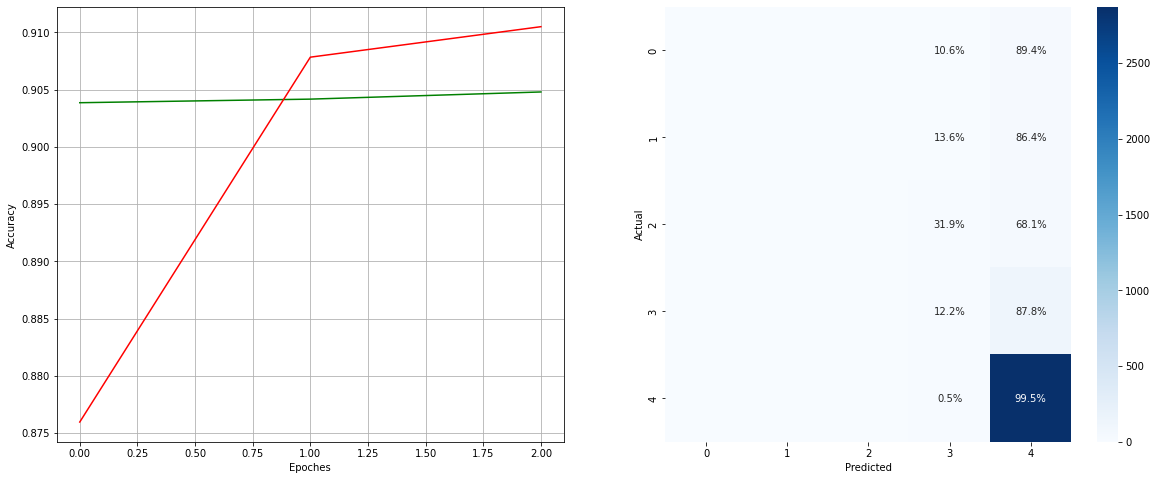

In [6]:
from utils.file_arguments_reader import load_param_from_file
from script.main_gradient_based_mt5 import train_model_t5_custom
from utils.logging_custom import make_logger
from utils.custom_dataloader import CustomDataset

# For deterministic results
random_seed = 64
np.random.seed(random_seed)
torch.manual_seed(random_seed)

if torch.cuda.is_available():
    torch.cuda.manual_seed(random_seed)
    torch.cuda.manual_seed_all(random_seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    
# Load train arguments from file
os.chdir("../")
wdir = os.getcwd() + "/" if not os.path.exists("/content/Rest_mex_DL_EDA/") else "/content/Rest_mex_DL_EDA/"  # only colab
dic_param = load_param_from_file(wdir + "script/arguments.txt")
log_exp_run = make_logger(name="" + dic_param['name_log_experiments_result'])
device = "cuda:" + str(dic_param['cuda_device_id']) if torch.cuda.is_available() else "cpu"

train_dataset = CustomDataset(torch.load(wdir + "/datasets/" + dic_param['dataset_train']))
val_dataset = CustomDataset(torch.load(wdir + "/datasets/" + dic_param['dataset_dev']))

gscv_best_model = None
gscv_best_model = train_model_t5_custom_polarity(dic_param, log_exp_run, wdir, device, train_dataset, val_dataset,
                                                   gscv_best_model)


**Train MT5 polarity prediction** 

In [ ]:
# Load train arguments from file
os.chdir("../")
wdir = os.getcwd() + "/" if not os.path.exists("/content/Rest_mex_DL_EDA/") else "/content/Rest_mex_DL_EDA/"  # only colab
dic_param = load_param_from_file(wdir + "script/arguments.txt")
log_exp_run = make_logger(name="" + dic_param['name_log_experiments_result'])
device = "cuda:" + str(dic_param['cuda_device_id']) if torch.cuda.is_available() else "cpu"

train_dataset = CustomDataset(torch.load(wdir + "/datasets/" + dic_param['dataset_train']))
val_dataset = CustomDataset(torch.load(wdir + "/datasets/" + dic_param['dataset_dev']))

gscv_best_model = None
gscv_best_model = train_model_t5_custom_attraction(dic_param, log_exp_run, wdir, device, train_dataset, val_dataset,
                                                   gscv_best_model)